In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
from numpy import linalg as LA
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
sns.set()
sns.set_style("whitegrid")

import os
from scipy.spatial.transform import Rotation as R

from plot_utils import plot_df_multiple, plot_df, parse_bag
import seaborn as sns
from matplotlib.widgets import Slider
import rosbag

USE_LATEX = True
if USE_LATEX:
    plt.rc('font', family='serif', serif='cm10')
    plt.rc('text', usetex=True)
    plt.rc('text.latex', preamble=r'\usepackage{gensymb}\usepackage{amsmath}')

sns.set()
sns.set_style("whitegrid")

In [2]:
df_dict = parse_bag('../log/log.bag', ["/drone_state", "/drone_control"])
simu_state_df = df_dict["/drone_state"]
simu_control_df = df_dict["/drone_control"]
t0 = min([df['t'][0] for df in df_dict.values()])
for df in df_dict.values():
    df['t'] -= t0

Loading: /drone_state
Loading: /drone_control


In [3]:
# radians to degrees
df_dict["/drone_state"][["yaw", "pitch", "roll", "wx", "wy", "wz"]] *= 180 / np.pi
df_dict["/drone_control"][["servo1", "servo2"]] *= 180 / np.pi

In [4]:
plot_ranges = {
    "t": [0, simu_state_df['t'].iloc[-1]],
    "x": [-1.5, 1.5],
    "y": [-1.5, 1.5],
    "z": [0.2, 2],
    "vx": [-1.5, 1.5],
    "vy": [-1.5, 1.5],
    "vz": [-1.5, 5],
    "yaw (x)": [-15, 15],
    "pitch (y)": [-15, 15],
    "roll (z)": [-90, 90],
    "dyaw (x)": [-20, 20],
    "dpitch (y)": [-20, 20],
    "droll (z)": [-4, 4],

    "servo1": [-15, 15],
    "servo2": [-15, 15],
    "bottom": [0, 100],
    "top": [0, 100],

    "thrust_scaling": [0, 1.5],
    "torque_scaling": [0, 1.5],
    "servo1_offset": [-3, 3],
    "servo2_offset": [-3, 3],
    "fx": [-6, 6],
    "fy": [-1, 1],
    "fz": [-1, 1],
    "mx": [-1, 1],
    "my": [-1, 1],
    "mz": [-1, 1],
}

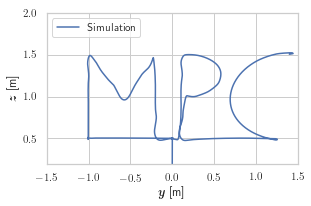

In [5]:
fig, axe = plt.subplots(1, 1, figsize=(4.5, 3.5))
plot_df(simu_state_df, 'y', 'z', axe, label=r"Simulation", scaled_xy=True, use_latex=USE_LATEX, plot_ranges=plot_ranges)
axe.legend(loc='upper left')
# fig.savefig('mpc_drawing.pdf',bbox_inches='tight')

In [6]:
simu_control_df['prop_average'] = (simu_control_df['bottom'] + simu_control_df['top']) / 2
simu_control_df['prop_delta'] = simu_control_df['top'] - simu_control_df['bottom']

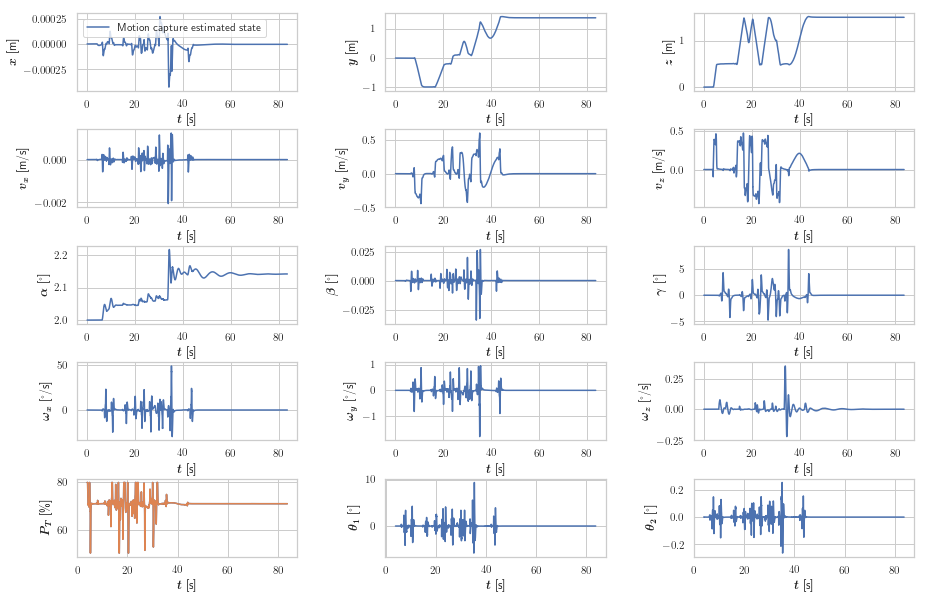

In [8]:
state_plot_indexes = {
    (0, 0): [("t", "x")],
    (0, 1): [("t", "y")],
    (0, 2): [("t", "z")],

    (1, 0): [("t", "vx")],
    (1, 1): [("t", "vy")],
    (1, 2): [("t", "vz")],

    (2, 0): [("t", "yaw")],
    (2, 1): [("t", "pitch")],
    (2, 2): [("t", "roll")],

    (3, 0): [("t", "wx")],
    (3, 1): [("t", "wy")],
    (3, 2): [("t", "wz")],
}
control_plot_indexes = {
    (4, 0): [("t", "bottom"), ("t", "top")],
    (4, 1): [("t", "servo1")],
    (4, 2): [("t", "servo2")],
}

fig, axe = plt.subplots(5, 3, figsize=(15, 10))
fig.subplots_adjust(wspace=0.4, hspace=0.5)

plot_df_multiple(simu_state_df, state_plot_indexes, axe, label=r"Motion capture estimated state", use_latex=USE_LATEX)
plot_df_multiple(simu_control_df, control_plot_indexes, axe, use_latex=USE_LATEX)

axe[0][0].legend(loc='upper left')

KeyError: 'servo1_offset'

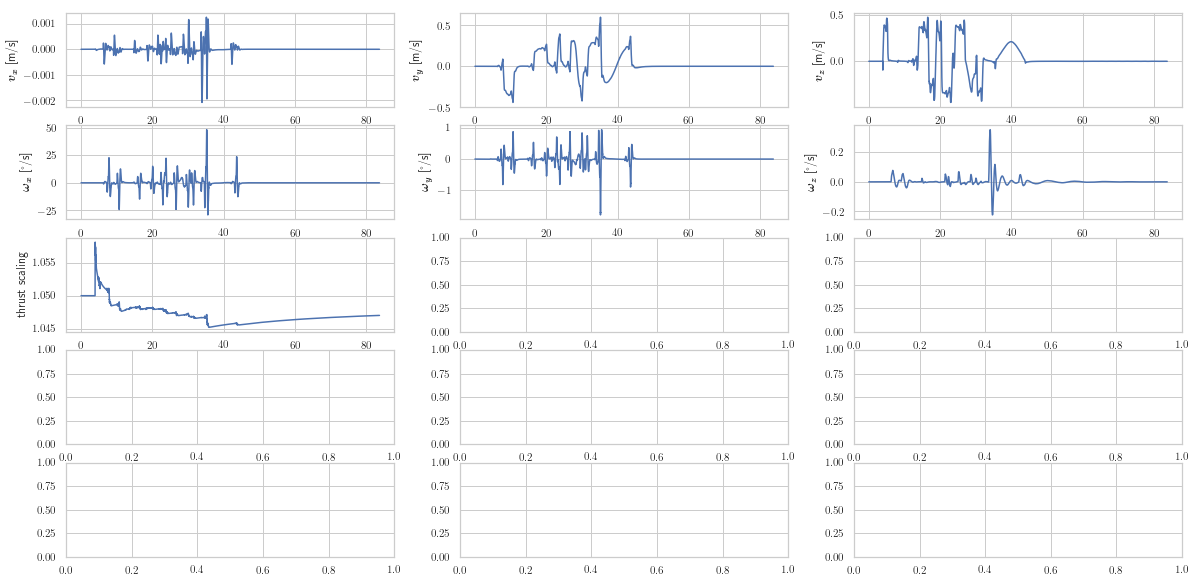

In [9]:
PLOT_FULL_STATE = True
if PLOT_FULL_STATE:
    kalman_plot_indexes = {
        (0, 0): [("t", "vx")],
        (0, 1): [("t", "vy")],
        (0, 2): [("t", "vz")],

        (1, 0): [("t", "wx")],
        (1, 1): [("t", "wy")],
        (1, 2): [("t", "wz")],

        (2, 0): [("t", "thrust_scaling")],
        (2, 1): [("t", "servo1_offset")],
        (2, 2): [("t", "servo2_offset")],

        (3, 0): [("t", "disturbance_torque_x")],
        (3, 1): [("t", "disturbance_torque_y")],
        (3, 2): [("t", "disturbance_torque_z")],

        (4, 0): [("t", "disturbance_force_x")],
        (4, 1): [("t", "disturbance_force_y")],
        (4, 2): [("t", "disturbance_force_z")],
    }

    fig_kalman, axe_kalman = plt.subplots(5, 3, figsize=(20, 10))
    plot_df_multiple(simu_state_df, kalman_plot_indexes, axe_kalman, label=r"Kalman state", use_latex=USE_LATEX)
    axe_kalman[0][0].legend(loc='upper left')